This is how much space the figure will take up on letter paper


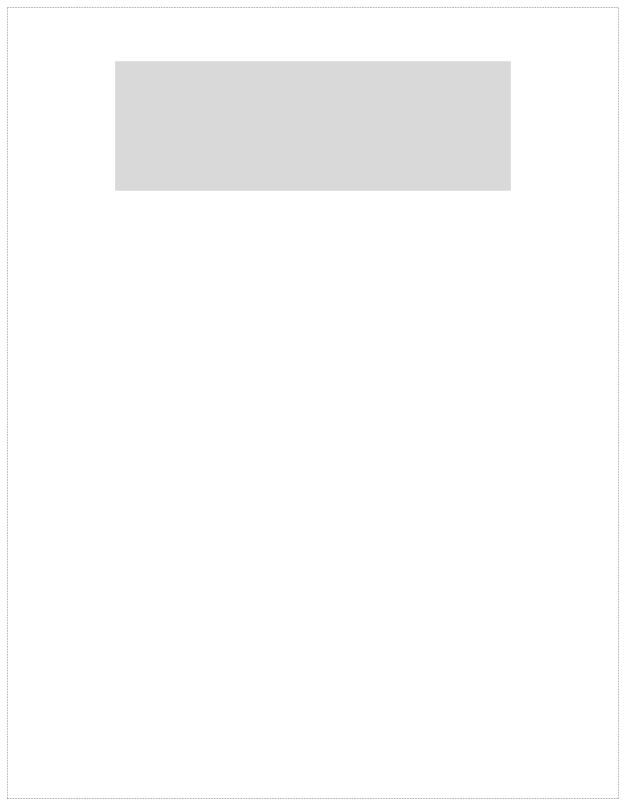

In [1]:
__PRODUCTION__ = 0
__NAME__       = 'efficiency'
__WIDTH__      = 5.5  # NeurIPS 2021 text box width
__HEIGHT__     = 1.8

if __PRODUCTION__:
    from mplmagic2 import pgf
else:
    from mplmagic2 import svg

from mplmagic2 import SuperFigure
import matplotlib.pyplot as plt

print('This is how much space the figure will take up on letter paper')
SuperFigure.size_hint(__WIDTH__, __HEIGHT__, margin_left=0.5 * (8.5 - __WIDTH__));

In [2]:
import functools
import numpy as np
import colorsys
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import networkx as nx
import json
import pickle

from symfac.experimental import RBFExpansionV2

In [3]:
rgn_losses = pickle.loads(open('data/paper/rgn_losses.pickle', 'rb').read())
gn_losses = pickle.loads(open('data/paper/gn_losses.pickle', 'rb').read())
er_losses = pickle.loads(open('data/paper/er_losses.pickle', 'rb').read())
ba_losses = pickle.loads(open('data/paper/ba_losses.pickle', 'rb').read())

In [4]:
data = {
    'rectangular-gaussian-noise': {
        'rbf': np.array(rgn_losses[0]),
        'svd': np.array(rgn_losses[1]),
    },
    'square-gaussian-noise': {
        'rbf': np.array(gn_losses[0]),
        'svd': np.array(gn_losses[1]),
    },
    'erdos-renyi': {
        'svd': np.array(er_losses[1]),
        'rbf': np.array(er_losses[0]),
    },
      'barabasi-albert': {
        'svd': np.array(ba_losses[1]),
        'rbf': np.array(ba_losses[0]),
    },
}

# open('data/efficiency.json', 'w').write(json.dumps(data))

<ipython-input-5-a87bdbb6a29a>:50: RuntimeWarning: divide by zero encountered in log2
  np.floor(np.log2(np.min(case['svd'])))
<ipython-input-5-a87bdbb6a29a>:60: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale('log', basey=2)


15 33
23 50
28 58


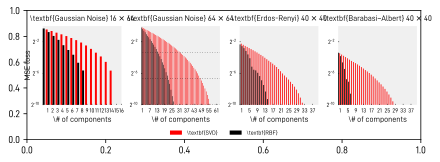

In [5]:
fig = SuperFigure(figsize=(__WIDTH__, __HEIGHT__), dpi=300)
ax_canvas = fig.make_axes(
    left=0, right=1, top=0, bottom=1, zorder=-100,
    style='blank' if __PRODUCTION__ else None
)
ax_canvas.set_xlim([0, 1])
ax_canvas.set_ylim([0, 1])

# draw the axes grid
x0 = 0.04
dx = 0.25
w = 0.20
axs = [
    fig.make_axes(
        left=x0 + dx * i,
        width=w,
        top=0.12,
        width_to_height=1.0,
        style='modern'
    ) for i in range(4)
]


def draw_bars(ax, h, offset, **kwargs):
    ax.bar(np.arange(len(h)) + offset, h, **kwargs)

bar_width = 0.4
bar_style = dict(
    width=bar_width
)
svd_style = dict(
    color='r',
    label=r'\textbf{SVD}'
)
rbf_style = dict(
    color='k',
    label=r'\textbf{RBF}'
)

for i, (ax, (key, case)) in enumerate(zip(axs, data.items())):
    draw_bars(ax, case['svd'], -0.5 * bar_width, **bar_style, **svd_style)
    draw_bars(ax, case['rbf'], 0.5 * bar_width, **bar_style, **rbf_style)
    n = np.max([len(val) for val in case.values()])
    ax.set_xbound(lower=0, upper=n)
    xticks = np.arange(1, n + 1, (n - 9) // 10 + 1)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, fontsize=6)
    logymin = np.maximum(
        -10,
        np.floor(np.log2(np.min(case['svd'])))
    )
    logymax = np.ceil(np.log2(np.max(case['svd'])))
    ax.set_ybound(lower=2**logymin, upper=2**logymax)
    ax.set_ylim([2**logymin, 2**logymax])
    yticks = 2**np.linspace(0, logymax, 2)
    ax.set_yticks(yticks)
    ax.set_yticklabels(['%g' % y for y in yticks], fontsize=6)
    ax.tick_params(axis='both', which='both', length=1)

    if i == 1:
        for ref in [0.1, 0.01, 0.001]:
            print(
                np.flatnonzero(case['rbf'] <= ref)[0] + 1,
                np.flatnonzero(case['svd'] <= ref)[0] + 1
            )
            ax.axhline(
                ref,
                color='k',
                lw=0.5,
                ls=(2, (1, 4)),
            )

label_style = dict(
    fontsize=8,
)
for i, ax in enumerate(axs):
    if i == 0:
        ax.set_ylabel(r'MSE loss', labelpad=0, **label_style)
    ax.set_xlabel(r'\# of components', labelpad=3, **label_style)
    
# draw_bars(axs[0], data['rectangular-gaussian-noise']['svd'], -0.5 * bar_width, **bar_style, **svd_style)
# draw_bars(axs[0], data['rectangular-gaussian-noise']['rbf'], 0.5 * bar_width, **bar_style, **rbf_style)

# draw_bars(axs[1], data['square-gaussian-noise']['svd'], -0.5 * bar_width, **bar_style, **svd_style)
# draw_bars(axs[1], data['square-gaussian-noise']['rbf'], 0.5 * bar_width, **bar_style, **rbf_style)

# draw_bars(axs[2], data['erdos-renyi']['svd'], -0.5 * bar_width, **bar_style, **svd_style)
# draw_bars(axs[2], data['erdos-renyi']['rbf'], 0.5 * bar_width, **bar_style, **rbf_style)
    
title_style = dict(
    fontsize=8,
    y=0.975,
    va='bottom'
)
axs[0].set_title(r'\textbf{Gaussian Noise} 16 $\times$ 64', **title_style)
axs[1].set_title(r'\textbf{Gaussian Noise} 64 $\times$ 64', **title_style)
axs[2].set_title(r'\textbf{Erdos-Renyi} 40 $\times$ 40', **title_style)
axs[3].set_title(r'\textbf{Barabasi–Albert} 40 $\times$ 40', **title_style)

ax_canvas.bar([-1], [0], **bar_style, **svd_style)
ax_canvas.bar([-1], [0], **bar_style, **rbf_style)
ax_canvas.legend(
    loc='center',
    bbox_to_anchor=(0.5, 0.05),
    ncol=2,
    frameon=False,
    fontsize=6
)


if __PRODUCTION__:
    fig.savefig(f'pgf/{__NAME__}.pgf', dpi=300)
else:
    fig.savefig(f'svg/{__NAME__}.svg', dpi=300)
plt.show()

In [6]:
np.flatnonzero(np.arange(10) >= 5)[0]

5

In [7]:
!make -f Makefile.figures fig-"$__NAME__".pdf 2>&1 | tail -n 1

make: 'fig-efficiency.pdf' is up to date.


END
---